In [7]:
import os

os.listdir('/content/')


['.config', 'combined_eeg_data_with_labels.csv', 'sample_data']

In [9]:
import pandas as pd
df_all = pd.read_csv('/content/combined_eeg_data_with_labels.csv')
X = df_all.drop(columns=['label'])  # Features (drop the label column)
y = df_all['label']  # Labels (the 'label' column)


In [16]:
X['file_name'] = X['file_name'].str.slice(0, -4)
X['file_name'] = X['file_name'].astype(int)

In [18]:
X.dtypes

,0
file_name,int64
channel,int64
frequency,int64
fft_magnitude,float64
Dominant Frequency,int64
Spectral Power,float64
Spectral Entropy,float64
Band Power Ratios (alpha/theta),float64
Spectral Edge Frequency (SEF),float64
Mean Frequency,float64


In [20]:
# Ensure correct imports
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Define Generator Model
def build_generator(latent_dim, output_dim):
    model = models.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(output_dim, activation='tanh')  # Match the dimension of features
    ])
    return model

# Define Discriminator Model
def build_discriminator(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Output for real/fake classification
    ])
    return model

# Train GAN
def train_gan(generator, discriminator, gan, real_data, latent_dim, epochs=100, batch_size=32):
    # Ensure real_data is a NumPy array
    if isinstance(real_data, pd.DataFrame):
        real_data = real_data.reset_index(drop=True).values  # Reset index and convert to NumPy array
    elif isinstance(real_data, np.ndarray):
        pass  # Already a NumPy array
    else:
        raise ValueError("real_data must be a pandas DataFrame or a NumPy array")

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, real_data.shape[0], batch_size)
        real_samples = real_data[idx]  # Safe indexing

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_samples = generator.predict(noise)

        labels_real = np.ones((batch_size, 1))
        labels_fake = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(real_samples, labels_real)
        d_loss_fake = discriminator.train_on_batch(fake_samples, labels_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator (via GAN)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        labels_gan = np.ones((batch_size, 1))  # Generator wants to fool the discriminator
        g_loss = gan.train_on_batch(noise, labels_gan)

        # Output progress
        if epoch % 10 == 0:
            # If d_loss or g_loss are arrays, get the mean of the batch losses
            print(f"Epoch {epoch}/{epochs} - D Loss: {np.mean(d_loss):.4f}, G Loss: {np.mean(g_loss):.4f}")



# Parameters
latent_dim = 20  # Adjust depending on your latent space preference
output_dim = X.shape[1]  # Match the number of features in your dataset
batch_size = 32

# Initialize models
generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(output_dim)
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Compile discriminator
gan = build_gan(generator, discriminator)

# Train GAN
train_gan(generator, discriminator, gan, real_data=X, latent_dim=latent_dim, epochs=1000, batch_size=batch_size)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Epoch 0/1000 - D Loss: 11.7150, G Loss: 10.4629
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 10/1000 - D Loss: 11.1600, G Loss: 14.3679
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 20/1000 - D Loss: 10.7583, G Loss: 14.0127
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━

In [25]:
num_samples = X.shape[0]  # Same number of samples as in the real data
noise = np.random.normal(0, 1, (num_samples, latent_dim))  # Generate noise
synthetic_data = generator.predict(noise)

3330/3330 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


In [26]:
synthetic_data = synthetic_data.reshape(num_samples, X.shape[1])  # Same number of features as real data

# Step 2: Split Data into Training and Validation Sets

# Split the real data into training and validation sets
X_train_real, X_val_real, y_train_real, y_val_real = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
X_train_synthetic, X_val_synthetic, y_train_synthetic, y_val_synthetic = train_test_split(synthetic_data, y, test_size=0.2, random_state=42)

# Step 3: Train Classifier on Real Data
from sklearn.ensemble import RandomForestClassifier  # This line imports the RandomForestClassifier
clf_real = RandomForestClassifier(n_estimators=100, random_state=42)
clf_real.fit(X_train_real, y_train_real)

RandomForestClassifier(random_state=42)

In [30]:
from sklearn.metrics import classification_report


In [32]:
clf_synthetic = RandomForestClassifier(n_estimators=100, random_state=42)
clf_synthetic.fit(X_train_synthetic, y_train_synthetic)


RandomForestClassifier(random_state=42)

In [33]:
# Step 5: Evaluate Classifier on Real Data
y_pred_real = clf_real.predict(X_val_real)
print("Performance on Real Data:")
print(classification_report(y_val_real, y_pred_real))

Performance on Real Data:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84     10488
           1       0.83      0.79      0.81      8355
           2       0.65      0.18      0.28      2155
           3       0.86      0.64      0.73       313

    accuracy                           0.79     21311
   macro avg       0.78      0.63      0.67     21311
weighted avg       0.78      0.79      0.77     21311



In [34]:
y_pred_synthetic = clf_synthetic.predict(X_val_synthetic)
print("Performance on Synthetic Data:")
print(classification_report(y_val_synthetic, y_pred_synthetic))

Performance on Synthetic Data:
              precision    recall  f1-score   support

           0       0.50      0.76      0.60     10488
           1       0.41      0.26      0.31      8355
           2       0.00      0.00      0.00      2155
           3       0.00      0.00      0.00       313

    accuracy                           0.47     21311
   macro avg       0.23      0.25      0.23     21311
weighted avg       0.40      0.47      0.42     21311



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
print("\nPerformance Comparison:")
print(f"Real Data Classifier Accuracy: {clf_real.score(X_val_real, y_val_real) * 100:.2f}%")
print(f"Synthetic Data Classifier Accuracy: {clf_synthetic.score(X_val_synthetic, y_val_synthetic) * 100:.2f}%")


Performance Comparison:
Real Data Classifier Accuracy: 79.13%
Synthetic Data Classifier Accuracy: 47.41%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


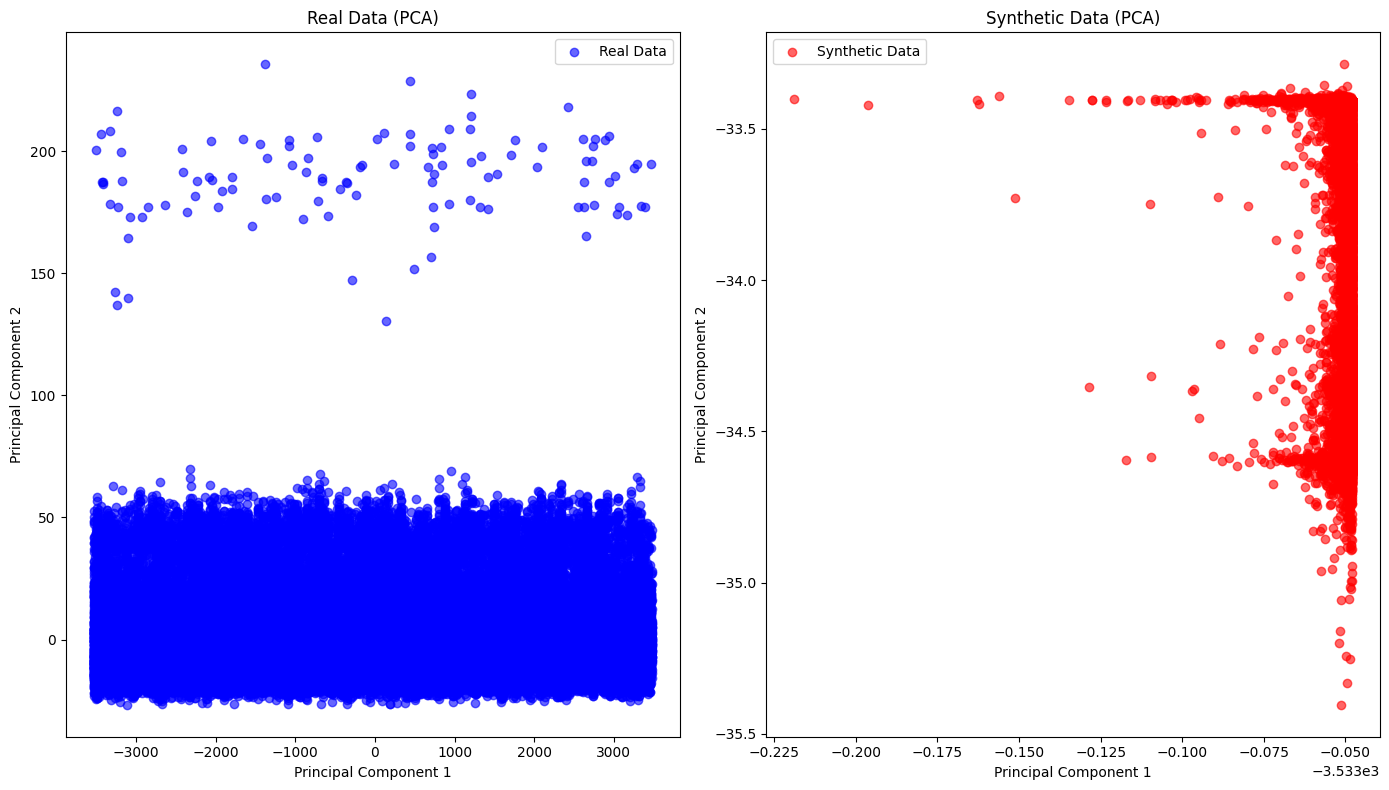

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA to reduce data to 2D
pca = PCA(n_components=2)

# Fit and transform both real and synthetic data
real_data_pca = pca.fit_transform(X)
synthetic_data_pca = pca.transform(synthetic_data)

# Create a figure to hold both plots
plt.figure(figsize=(14, 8))

# Plot for real data
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.scatter(real_data_pca[:, 0], real_data_pca[:, 1], c='blue', label='Real Data', alpha=0.6)
plt.title('Real Data (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Plot for synthetic data
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.scatter(synthetic_data_pca[:, 0], synthetic_data_pca[:, 1], c='red', label='Synthetic Data', alpha=0.6)
plt.title('Synthetic Data (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()
